# ARMA and ARIMA Models 

In [1]:
##Developer:Tomás Tapia Barría
##Proyect: Arma an Arima Model

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Simulate ARMA process (1,1) 

In [2]:
ar1 = np.array([1, 0.33])
ma1 = np.array([1, 0.9])

simulated_ARMA_data = ArmaProcess(ar1, ma1).generate_sample(nsample=10000)

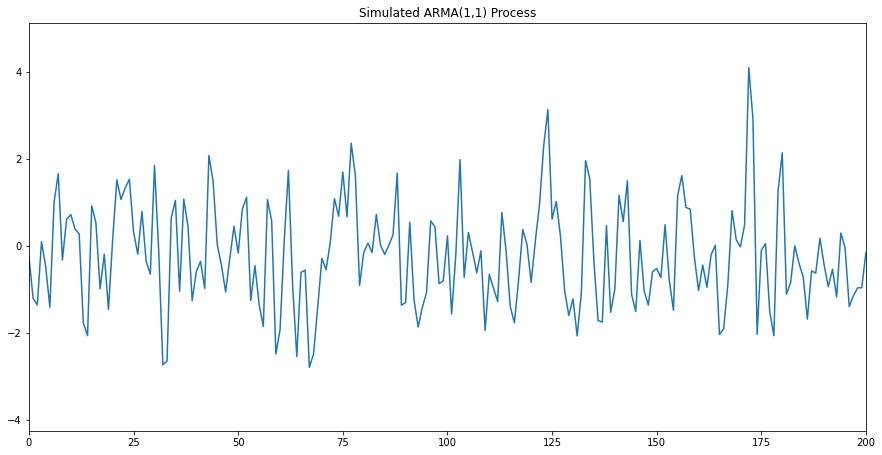

In [3]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(simulated_ARMA_data)
plt.title("Simulated ARMA(1,1) Process")
plt.xlim([0, 200])
plt.show()

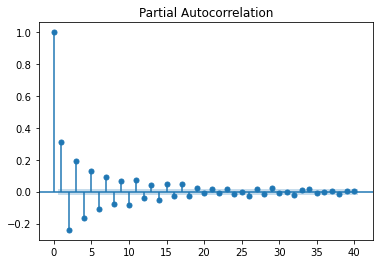

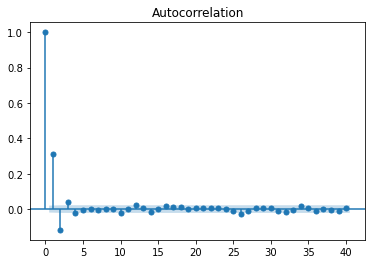

In [4]:
plot_pacf(simulated_ARMA_data);
plot_acf(simulated_ARMA_data);

## Simulate ARMA (2,2) process 

In [5]:
ar2 = np.array([1, 0.33, 0.5])
ma2 = np.array([1, 0.9, 0.3])

simulated_ARMA2_data = ArmaProcess(ar1, ma1).generate_sample(nsample=10000)

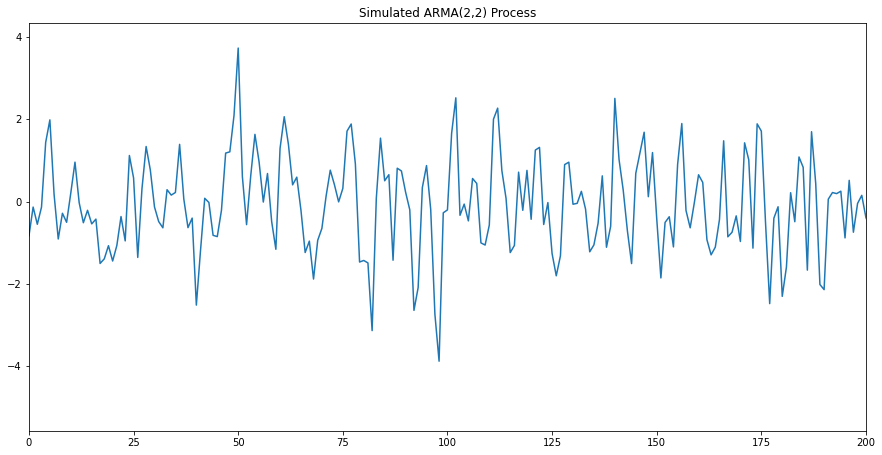

In [6]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(simulated_ARMA2_data)
plt.title("Simulated ARMA(2,2) Process")
plt.xlim([0, 200])
plt.show()

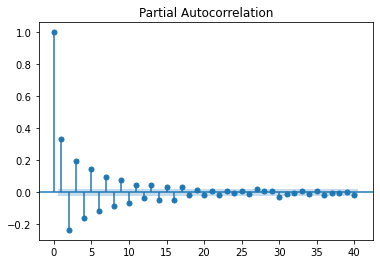

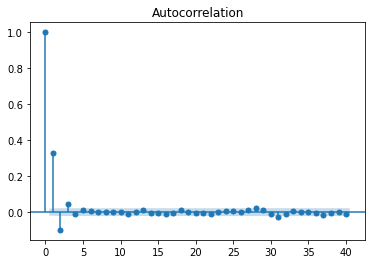

In [7]:
plot_pacf(simulated_ARMA2_data);
plot_acf(simulated_ARMA2_data);

## ARIMA 

In [9]:
data = pd.read_csv(r'C:\Users\acer\Documents\misdocumentos\MATERIAL DE ESTUDIO\analysis_time_series\time-series-analysis\data\jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


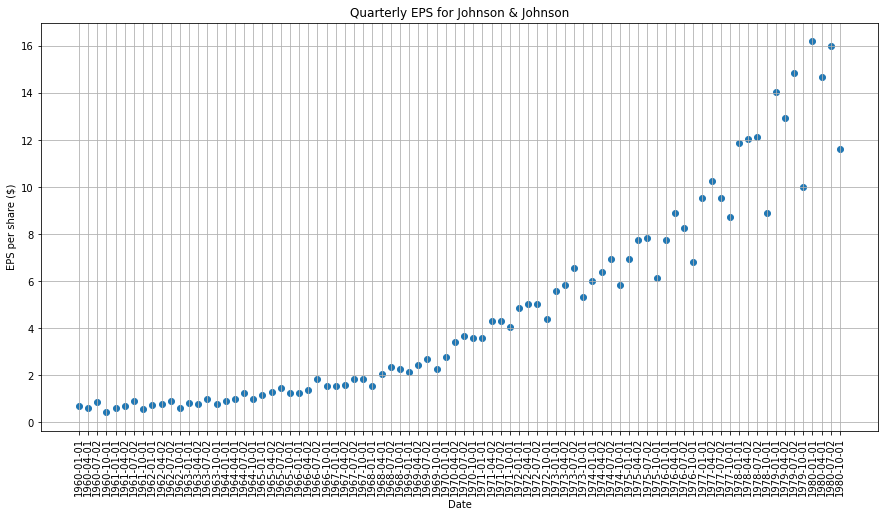

In [10]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.scatter(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

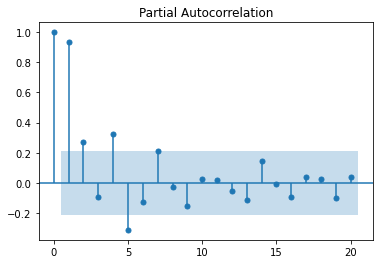

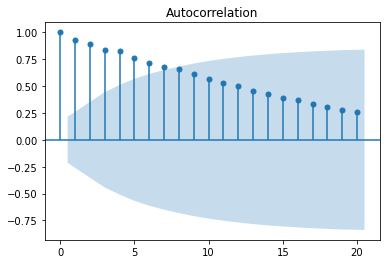

In [11]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [12]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574753
p-value: 1.0


In [13]:
# Take the log difference to make data stationary

data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])
data.head()

,date,data
1,1960-04-01,-0.119545
2,1960-07-02,0.299517
3,1960-10-01,-0.658462
4,1961-01-01,0.326684
5,1961-04-02,0.123233


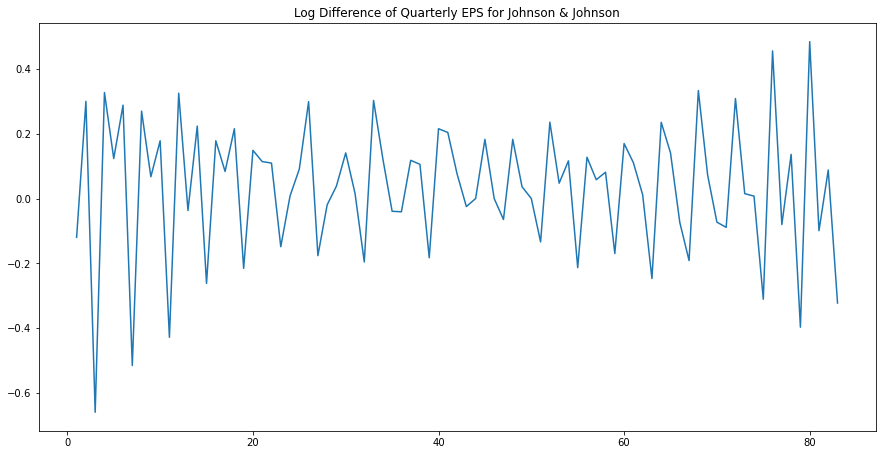

In [14]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [15]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811826
p-value: 0.0004149731404440838


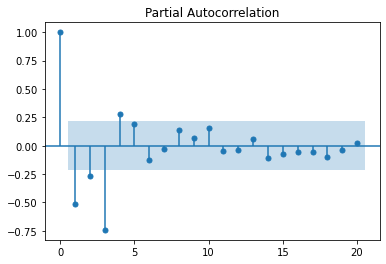

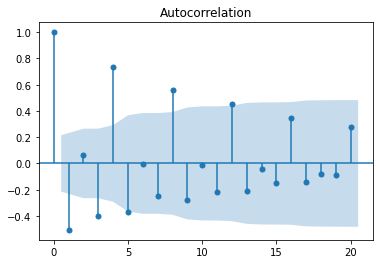

In [16]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [17]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [18]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=data['data'])

result_df

,"(p, d, q)",AIC
0,"(7, 1, 1)",-142.134939
1,"(3, 1, 3)",-142.041805
2,"(7, 1, 5)",-140.612726
3,"(3, 1, 1)",-140.470763
4,"(3, 1, 4)",-140.461193
...,...,...
59,"(1, 1, 1)",-37.106604
60,"(0, 1, 1)",-14.645882
61,"(2, 1, 0)",14.952068
62,"(1, 1, 0)",17.545808


In [19]:
best_model = SARIMAX(data['data'], order=(4,1,1)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   83
Model:               SARIMAX(4, 1, 1)   Log Likelihood                  76.200
Date:                Wed, 26 May 2021   AIC                           -140.401
Time:                        17:14:55   BIC                           -125.960
Sample:                             0   HQIC                          -134.603
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7723      0.144     -5.360      0.000      -1.055      -0.490
ar.L2         -0.7022      0.146     -4.823      0.000      -0.988      -0.417
ar.L3         -0.7116      0.150     -4.734      0.0

In [20]:
# Ljung-Box test and Augmented Dickey-Fuller test
ljung_box, p_value = acorr_ljungbox(best_model.resid)

print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [ 5.48872044  6.0683563   6.15785455  7.65877912  7.7944869   7.96563158
 10.85204931 10.85647038 10.9798305  11.39519171]
p-value: [0.01913955 0.04811419 0.10417779 0.10490821 0.16793149 0.24063206
 0.14520402 0.20996517 0.27709399 0.32756874]


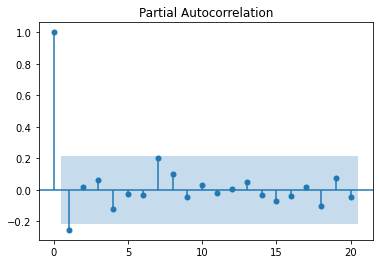

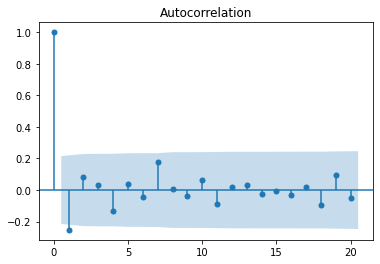

In [21]:
plot_pacf(best_model.resid);
plot_acf(best_model.resid);